<a href="https://colab.research.google.com/github/VanesaHM/ProyectoKaggle/blob/main/04_modelo_con_preprocesado_(KNNImputer%2C_OHE%2C_RobustScaler%2C_SMOTE)_y_Random_Forest_%2B_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia**

Crear un modelo para predecir el rendimiento de los estudiantes en las pruebas Saber Pro

# **Descripción general**

Las Pruebas Saber Pro son exámenes estandarizados que se administran en Colombia para evaluar la calidad y el nivel de conocimiento y competencias de los estudiantes de educación superior, es decir, de instituciones de educación superior como universidades y tecnológicos. Estas pruebas son parte de los esfuerzos del Gobierno de Colombia para monitorear y mejorar la calidad de la educación superior en el país.

Estas Pruebas constan cinco componentes genéricos, Inglés, Lectura Crítica, Competencias Ciudadanas, Razonamiento Cuantitativo y Comunicación Escrita.

Tu tarea será crear un modelo de clasificación que para cada estudiante prediga qué desempeño va a tener: bajo, medio-bajo, medio-alto o alto.

# **Descripción**

El conjunto de datos contiene más de 50 columnas que describen de manera distintos aspectos de cada estudiante, incluyendo:

Información socieconómica: Describen características socieconómicas del estudiante como su estrato, educación de sus padres, estrato, entre otras.

Información de instituciones: Describen las instituciones de donde provienen los estudiantes.

Información del estudiante: Describe particularidades del estudiante como su edad, que programa estudian, la modalidad de estudio, etc.

Información estadística: Describe algunos coeficientes que equipos de estudio han desarrollado que podría ayudar a la clasificación.

Así como muchos otros datos que ayudan a clasificar de manera precisa los niveles de desempeño

# **modelo con preprocesado (KNNImputer, OHE, RobustScaler, SMOTE) y Random Forest + Gradient Boosting**



**1. Importar librerías**

In [ ]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, train_test_split


**2. Configuración visual**

In [ ]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")

**3. Cargar los datos**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.37GB/s]


**4. Descomprimir los datos**

In [ ]:
!unzip udea*.zip > /dev/null

In [ ]:
train = pd.read_csv("train.csv")
test  = pd.read_csv('test.csv')

# **ANÁLISIS EXPLORATORIO INICIAL**

Se muestran las primeras filas, tipos y valores nulos.

In [ ]:
if train is not None:
    display(train.head())
    display(train.info())
    display(train.isna().sum().sort_values(ascending=False).head(20))
else:
    print('No train available to display.')

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO        686002 non-null  object 
 13 

None

,0
F_TIENEAUTOMOVIL,43623
F_TIENELAVADORA,39773
F_TIENECOMPUTADOR,38103
F_ESTRATOVIVIENDA,32137
E_HORASSEMANATRABAJA,30857
F_TIENEINTERNET.1,26629
F_TIENEINTERNET,26629
F_EDUCACIONMADRE,23664
F_EDUCACIONPADRE,23178
E_PAGOMATRICULAPROPIO,6498


# **PREPROCESAMIENTO**

In [ ]:
# CONFIGURACIÓN

train_processed = train.copy()
inicio = time.time()

ID_COL = "ID"
TARGET = "RENDIMIENTO_GLOBAL"
NUM_VARS = ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
ESTRATO_MAP = {f'Estrato {i}': i for i in range(1, 7)}
REVERSE_ESTRATO = {v: k for k, v in ESTRATO_MAP.items()}
TEST_SIZE = 0.2
RANDOM_STATE = 42
SAMPLE_FRAC = 0.5

print("\n=== PREPROCESAMIENTO PARA ~700K FILAS ===")
print(f"Filas originales: {len(train_processed):,}")

# SAMPLING ESTRATIFICADO
if len(train_processed) > 200000:
    print(f"\nAplicando stratified sampling al {SAMPLE_FRAC*100:.0f}%...")
    train_sample, _ = train_test_split(
        train_processed, train_size=SAMPLE_FRAC, random_state=RANDOM_STATE,
        stratify=train_processed[TARGET]
    )
    train_processed = train_sample.reset_index(drop=True)
    print(f"Filas después del sampling: {len(train_processed):,}")

# 1. LIMPIEZA RÁPIDA

cols_drop = [c for c in train_processed.columns if ".1" in c]
train_processed.drop(columns=cols_drop, inplace=True, errors='ignore')

cat_vars = [c for c in train_processed.columns if c not in NUM_VARS + [ID_COL, TARGET]]

print(f"\nNuméricas: {NUM_VARS}")
print(f"Categóricas: {len(cat_vars)}")

# 2. IMPUTACIÓN F_ESTRATOVIVIENDA

if "F_ESTRATOVIVIENDA" in train_processed.columns:
    print("\nImputando F_ESTRATOVIVIENDA...")
    socio_vars = [
        'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR', 'F_TIENELAVADORA',
        'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE',
        'E_VALORMATRICULAUNIVERSIDAD'
    ]
    socio_vars = [v for v in socio_vars if v in train_processed.columns]

    temp = train_processed[socio_vars + ["F_ESTRATOVIVIENDA"]].copy()
    for col in socio_vars:
        temp[col] = temp[col].astype("category").cat.codes.replace({-1: np.nan})

    temp["F_ESTRATOVIVIENDA"] = temp["F_ESTRATOVIVIENDA"].map(ESTRATO_MAP)

    imputer = KNNImputer(n_neighbors=3, weights="distance")
    imputado = np.round(imputer.fit_transform(temp)[:, -1]).clip(1, 6)
    train_processed["F_ESTRATOVIVIENDA"] = pd.Series(imputado, index=train_processed.index).map(REVERSE_ESTRATO)

    del temp, imputer, imputado

# 3. IMPUTACIÓN CATEGÓRICAS

print("Imputando categóricas...")
for col in cat_vars:
    if train_processed[col].isnull().sum() > 0:
        fill_value = train_processed[col].mode()[0] if train_processed[col].nunique() <= 3 else "Desconocido"
        train_processed[col].fillna(fill_value, inplace=True)

# 4. OUTLIERS - CAPPING

print("Capping outliers...")
for col in NUM_VARS:
    p1, p99 = train_processed[col].quantile([0.01, 0.99])
    train_processed[col] = train_processed[col].clip(p1, p99)

# 5. ANÁLISIS CORRELACIÓN

le_temp = LabelEncoder()
target_encoded = le_temp.fit_transform(train_processed[TARGET])

print("\nCorrelaciones con TARGET:")
vars_to_keep = []
for col in NUM_VARS:
    corr = np.corrcoef(train_processed[col], target_encoded)[0, 1]
    if abs(corr) > 0.05:
        print(f"{col}: {corr:.4f}")
        vars_to_keep.append(col)
    else:
        print(f"{col}: {corr:.4f} (removida)")

NUM_VARS = vars_to_keep if vars_to_keep else NUM_VARS

# 6. SEPARAR TRAIN/TEST
print("\nTrain/Test split...")
X = train_processed[NUM_VARS + cat_vars]
y = train_processed[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

del train_processed, X, y
print(f"Train: {len(X_train):,}, Test: {len(X_test):,}")

# 7. TRANSFORMACIÓN PIPELINE
print("Ajustando transformaciones...")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), NUM_VARS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True, max_categories=50), cat_vars)
    ],
    remainder="drop"
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

cat_ohe_cols = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_vars)
final_cols = NUM_VARS + list(cat_ohe_cols)

print(f"Features finales: {len(final_cols)}")

# 8. CODIFICAR TARGET
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"Classes: {dict(zip(le.classes_, range(len(le.classes_))))}")

# 9. GUARDAR
print("\nGuardando archivos...")

df_train = pd.DataFrame(X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed, columns=final_cols)
df_train[TARGET] = y_train.values
df_train.to_parquet("train_processed.parquet", compression="snappy")

df_test = pd.DataFrame(X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed, columns=final_cols)
df_test[TARGET] = y_test.values
df_test.to_parquet("test_processed.parquet", compression="snappy")

with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

with open("data_for_training.pkl", "wb") as f:
    pickle.dump({
        'X_train': X_train_processed,
        'X_test': X_test_processed,
        'y_train': y_train_encoded,
        'y_test': y_test_encoded,
        'le': le,
        'final_cols': final_cols
    }, f)

# RESUMEN
tiempo_total = time.time() - inicio
print("\n" + "="*50)
print("PREPROCESAMIENTO COMPLETADO")
print("="*50)
print(f"Tiempo total: {tiempo_total/60:.2f} minutos")
print(f"Train: {len(df_train):,} | Test: {len(df_test):,}")
print(f"Features: {len(final_cols)}")
print("="*50)



=== PREPROCESAMIENTO OPTIMIZADO PARA ~700K FILAS ===
Filas originales: 346,250

⚡ Aplicando stratified sampling al 50%...
✓ Filas después del sampling: 173,125

✓ Numéricas: ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
✓ Categóricas: 13

⚙️  Imputando F_ESTRATOVIVIENDA...
⚙️  Imputando categóricas...


/tmp/ipython-input-4040355402.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_processed[col].fillna(fill_value, inplace=True)


⚙️  Capping outliers...

📊 Correlaciones con TARGET:
  PERIODO_ACADEMICO: -0.0195 (removida)
  INDICADOR_1: -0.1501
  INDICADOR_2: 0.1137
  INDICADOR_3: 0.0107 (removida)
  INDICADOR_4: 0.1011

✂️  Train/Test split...
✓ Train: 138,500, Test: 34,625
🔄 Ajustando transformaciones...
✓ Features finales: 143
✓ Classes: {'alto': 0, 'bajo': 1, 'medio-alto': 2, 'medio-bajo': 3}

💾 Guardando archivos...

✅ PREPROCESAMIENTO COMPLETADO
⏱️  Tiempo total: 8.96 minutos
📊 Train: 138,500 | Test: 34,625
🎯 Features: 143


# **ENTRENAMIENTO**

📂 Cargando datos preprocesados...

✓ Datos cargados: Train (138500, 143), Test (34625, 143)
✓ Classes: {'alto': 0, 'bajo': 1, 'medio-alto': 2, 'medio-bajo': 3}

📊 DISTRIBUCIÓN DE CLASES:
  alto: 35,123 (25.4%)
  bajo: 34,598 (25.0%)
  medio-alto: 34,324 (24.8%)
  medio-bajo: 34,455 (24.9%)

Imbalance ratio: 1.02

✓ SMOTE omitido (balanceo aceptable)

🌲 MODELO 1: RANDOM FOREST

🔄 Validación cruzada (3-fold)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.0s
[Parall

CV F1-Weighted: 0.3842 (+/- 0.0003)

🔨 Entrenando modelo completo...


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s



🎯 Prediciendo en TEST...


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished



📊 RESULTADOS RANDOM FOREST:
  Accuracy:  0.4010
  F1-Score:  0.3844
  Precision: 0.3820
  Recall:    0.4010

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        alto     0.4873    0.6163    0.5442      8781
        bajo     0.4151    0.5308    0.4659      8649
  medio-alto     0.3105    0.2165    0.2551      8581
  medio-bajo     0.3126    0.2350    0.2683      8614

    accuracy                         0.4010     34625
   macro avg     0.3814    0.3997    0.3834     34625
weighted avg     0.3820    0.4010    0.3844     34625


📈 MODELO 2: GRADIENT BOOSTING

🔄 Validación cruzada (3-fold)...
      Iter       Train Loss   Remaining Time 
         1           1.3609            7.93m
         2           1.3407            8.72m
         3           1.3240            8.35m
         4           1.3094            8.24m
         5           1.2971            8.30m
         6           1.2861            8.14m
         7           1.2767            8.18m
 

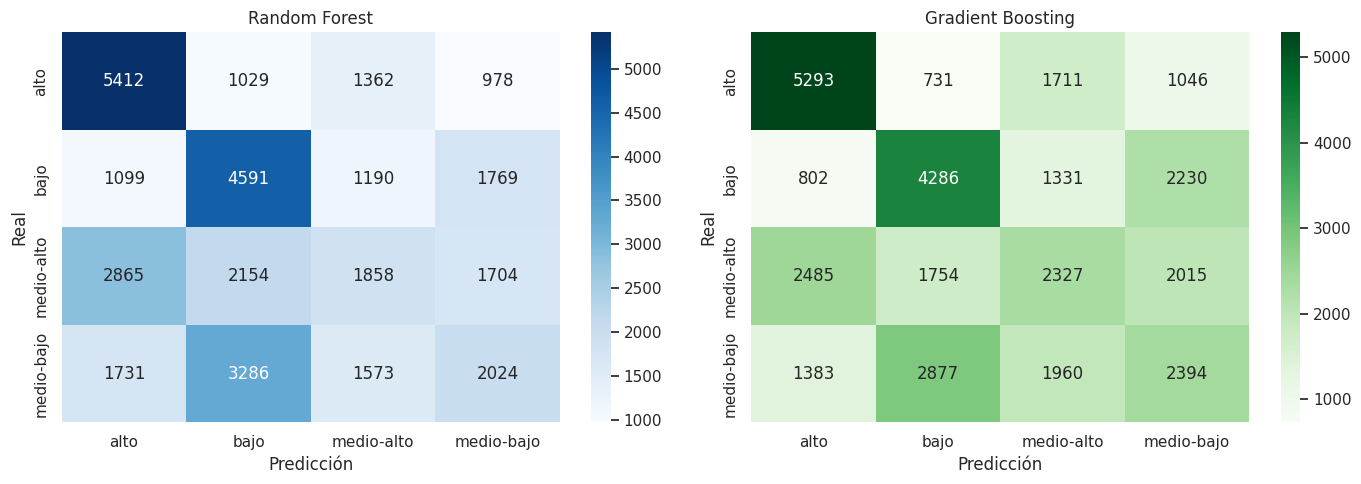


⭐ TOP 20 FEATURES MÁS IMPORTANTES (Random Forest)

                                                             Feature  Importance
                       E_VALORMATRICULAUNIVERSIDAD_Más de 7 millones    0.087364
                                                         INDICADOR_1    0.076189
                                                         INDICADOR_2    0.068094
                                                         INDICADOR_4    0.055038
  E_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones    0.048679
                                            E_PAGOMATRICULAPROPIO_No    0.035986
                                            E_PAGOMATRICULAPROPIO_Si    0.029465
                                              E_HORASSEMANATRABAJA_0    0.019533
                                          F_EDUCACIONPADRE_Postgrado    0.018253
                                          F_EDUCACIONMADRE_Postgrado    0.017749
E_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de

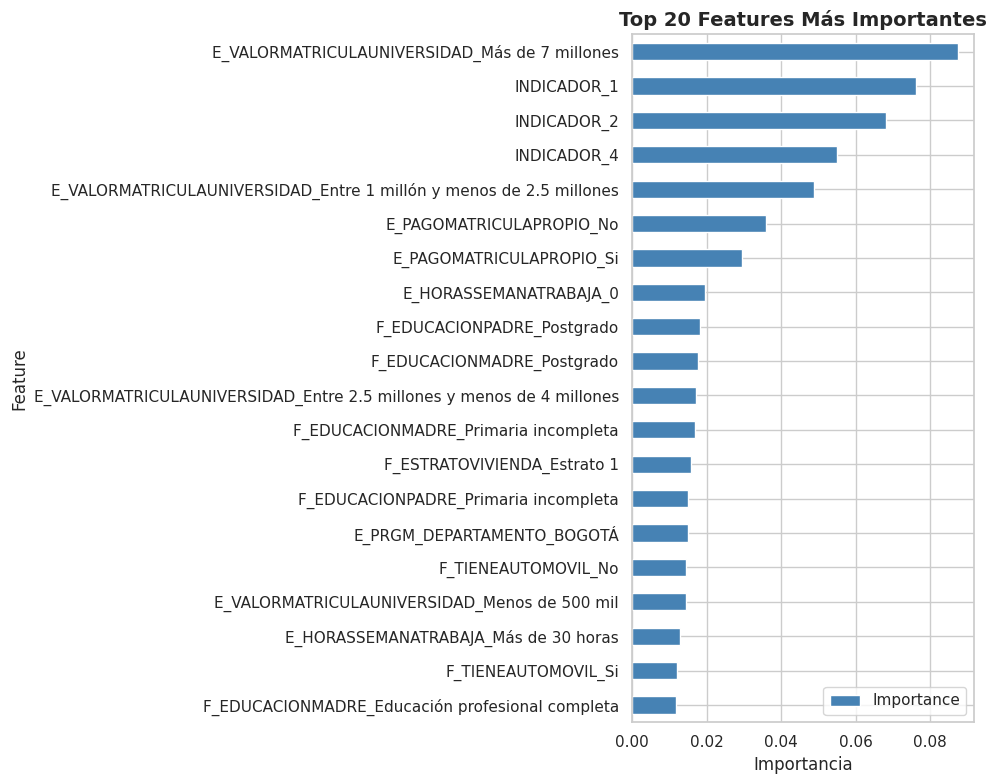


💾 Guardando modelos entrenados...

✅ ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS


In [ ]:
# CARGAR DATOS PREPROCESADOS

print("Cargando datos preprocesados...\n")

with open("data_for_training.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
le = data['le']
final_cols = data['final_cols']

print(f"Datos cargados: Train {X_train.shape}, Test {X_test.shape}")
print(f"Classes: {dict(zip(le.classes_, range(len(le.classes_))))}")

# ANALISIS DE BALANCEO
print("\nDistribución de clases:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {le.classes_[cls]}: {cnt:,} ({cnt/len(y_train)*100:.1f}%)")

class_counts = np.bincount(y_train)
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

# APLICAR SMOTE SI NECESARIO
if imbalance_ratio > 2.5:
    print("\nAplicando SMOTE...")
    smote = SMOTE(random_state=42, n_jobs=-1, k_neighbors=3, sampling_strategy='not majority')
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"Train balanceado: {len(X_train_balanced):,} muestras")
else:
    print("\nSMOTE omitido (balanceo aceptable)")
    X_train_balanced, y_train_balanced = X_train, y_train

# 1. RANDOM FOREST

print("\n" + "="*60)
print("MODELO RANDOM FOREST")
print("="*60)

rf = RandomForestClassifier(
    n_estimators=100, max_depth=15, max_features='sqrt',
    random_state=42, n_jobs=-1, verbose=1
)

print("\nValidación cruzada (3-fold)...")
cv_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=3, scoring='f1_weighted')
print(f"CV F1-Weighted: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\nEntrenando modelo completo...")
rf.fit(X_train_balanced, y_train_balanced)

print("\nPrediciendo en TEST...")
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
prec_rf = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_pred_rf, average='weighted')

print("\nResultados Random Forest:")
print(f"  Accuracy:  {acc_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")
print(f"  Precision: {prec_rf:.4f}")
print(f"  Recall:    {rec_rf:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, digits=4))

# 2. GRADIENT BOOSTING
print("\n" + "="*60)
print("MODELO 2: GRADIENT BOOSTING")
print("="*60)

gb = GradientBoostingClassifier(
    n_estimators=100, max_depth=8, learning_rate=0.1,
    random_state=42, verbose=1
)

print("\nValidación cruzada (3-fold)...")
cv_scores_gb = cross_val_score(gb, X_train_balanced, y_train_balanced, cv=3, scoring='f1_weighted')
print(f"CV F1-Weighted: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})")

print("\nEntrenando modelo completo...")
gb.fit(X_train_balanced, y_train_balanced)

print("\nPrediciendo en TEST...")
y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')
prec_gb = precision_score(y_test, y_pred_gb, average='weighted')
rec_gb = recall_score(y_test, y_pred_gb, average='weighted')

print("\nResultados Gradient Boosting:")
print(f"  Accuracy:  {acc_gb:.4f}")
print(f"  F1-Score:  {f1_gb:.4f}")
print(f"  Precision: {prec_gb:.4f}")
print(f"  Recall:    {rec_gb:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_, digits=4))

# COMPARACIÓN DE MODELOS
print("\n" + "="*60)
print("COMPARACIÓN DE MODELOS")
print("="*60)

comparacion = pd.DataFrame({
    'Random Forest': [acc_rf, f1_rf, prec_rf, rec_rf],
    'Gradient Boosting': [acc_gb, f1_gb, prec_gb, rec_gb]
}, index=['Accuracy', 'F1-Score', 'Precision', 'Recall'])

print("\n" + comparacion.to_string())

mejor_modelo = 'Random Forest' if acc_rf > acc_gb else 'Gradient Boosting'
print(f"\nMejor modelo: {mejor_modelo}")

# MATRIZ DE CONFUSIÓN
print("\n" + "="*60)
print("MATRICES DE CONFUSION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title('Random Forest')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicción')

cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title('Gradient Boosting')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predicción')

plt.tight_layout()
plt.show()

# IMPORTANCIA DE FEATURES (Random Forest)

print("\n" + "="*60)
print("TOP 20 FEATURES MAS IMPORTANTES (Random Forest)")
print("="*60)

feature_importance = pd.DataFrame({
    'Feature': final_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + feature_importance.head(20).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 8))
feature_importance.head(20).sort_values('Importance').plot(
    kind='barh', x='Feature', y='Importance', ax=ax, color='steelblue'
)
ax.set_title('Top 20 Features Más Importantes', fontsize=14, fontweight='bold')
ax.set_xlabel('Importancia')
plt.tight_layout()
plt.show()

# GUARDAR MODELOS

print("\nGuardando modelos entrenados...")

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open("gradient_boosting_model.pkl", "wb") as f:
    pickle.dump(gb, f)

print("\nEntrenamiento y evaluación completados")
print("="*60)


In [ ]:
# CARGAR MODELO Y PREPROCESADOR

print("Cargando modelo y preprocesador...\n")

# Cargar modelo entrenado (Gradient Boosting)
with open("gradient_boosting_model.pkl", "rb") as f:
    modelo = pickle.load(f)

# Cargar label encoder
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Cargar preprocessor
with open("preprocessor.pkl", "rb") as f:
    preprocessor = pickle.load(f)

print("Modelo cargado")
print(f"Clases: {le.classes_}")

# CARGAR DATASET ORIGINAL SIN SAMPLEAR

print("\nCargando dataset original sin samplear...\n")

test_original = test.copy()

print(f"Test original shape: {test_original.shape}")
print("Expected rows: 296,786")

if len(test_original) != 296786:
    print(f"ADVERTENCIA: Se esperaban 296,786 filas pero se cargaron {len(test_original):,}")

# PREPROCESAR DATASET COMPLETO

print("\nPreprocesando dataset completo...\n")
inicio = time.time()

ID_COL = "ID"
TARGET = "RENDIMIENTO_GLOBAL"
NUM_VARS = ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
ESTRATO_MAP = {f'Estrato {i}': i for i in range(1, 7)}
REVERSE_ESTRATO = {v: k for k, v in ESTRATO_MAP.items()}

test_proc = test_original.copy()

# 1. Limpiar duplicadas
cols_drop = [c for c in test_proc.columns if ".1" in c]
test_proc.drop(columns=cols_drop, inplace=True, errors='ignore')

cat_vars = [c for c in test_proc.columns if c not in NUM_VARS + [ID_COL]]

print("Columnas duplicadas eliminadas")

# 2. Imputar F_ESTRATOVIVIENDA
if "F_ESTRATOVIVIENDA" in test_proc.columns:
    socio_vars = [
        'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR', 'F_TIENELAVADORA',
        'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE',
        'E_VALORMATRICULAUNIVERSIDAD'
    ]
    socio_vars = [v for v in socio_vars if v in test_proc.columns]

    temp = test_proc[socio_vars + ["F_ESTRATOVIVIENDA"]].copy()
    for col in socio_vars:
        temp[col] = temp[col].astype("category").cat.codes.replace({-1: np.nan})

    temp["F_ESTRATOVIVIENDA"] = temp["F_ESTRATOVIVIENDA"].map(ESTRATO_MAP)

    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=3, weights="distance")
    imputado = np.round(imputer.fit_transform(temp)[:, -1]).clip(1, 6)
    test_proc["F_ESTRATOVIVIENDA"] = pd.Series(imputado, index=test_proc.index).map(REVERSE_ESTRATO)

    del temp, imputer, imputado

print("F_ESTRATOVIVIENDA imputado")

# 3. Imputar categóricas
for col in cat_vars:
    if test_proc[col].isnull().sum() > 0:
        fill_value = test_proc[col].mode()[0] if test_proc[col].nunique() <= 3 else "Desconocido"
        test_proc[col] = test_proc[col].fillna(fill_value)

print("Categóricas imputadas")

# 4. Capping outliers
for col in NUM_VARS:
    p1, p99 = test_proc[col].quantile([0.01, 0.99])
    test_proc[col] = test_proc[col].clip(p1, p99)

print("Outliers cappeados")

# APLICAR TRANSFORMACIONES

print("\nAplicando transformaciones...\n")

X_test = test_proc[NUM_VARS + cat_vars]
X_test_processed = preprocessor.transform(X_test)

print(f"Transformaciones aplicadas: {X_test_processed.shape}")

# HACER PREDICCIONES
print("\nHaciendo predicciones...\n")

# Predicciones (clases)
y_pred_encoded = modelo.predict(X_test_processed)

# Convertir códigos a clases
y_pred = le.inverse_transform(y_pred_encoded)

print(f"Predicciones completadas: {len(y_pred)} muestras")

📂 Cargando modelo y preprocesador...

✓ Modelo cargado
✓ Classes: ['alto' 'bajo' 'medio-alto' 'medio-bajo']

📂 Cargando dataset original sin samplear...

✓ Test original shape: (296786, 20)
✓ Expected rows: 296,786

⚙️  Preprocesando dataset completo...

✓ Columnas duplicadas eliminadas
✓ F_ESTRATOVIVIENDA imputado
✓ Categóricas imputadas
✓ Outliers cappeados

🔄 Aplicando transformaciones...

✓ Transformaciones aplicadas: (296786, 143)

🔮 Haciendo predicciones en {len(X_test):,} muestras...

✓ Predicciones completadas: 296786 muestras

📊 Creando archivo de envío...

✓ Shape: (296786, 2)
✓ Filas: 296,786
✓ Columnas: ['ID', 'RENDIMIENTO_GLOBAL']

📈 DISTRIBUCIÓN DE PREDICCIONES:
  alto: 84,931 (28.6%)
  bajo: 81,713 (27.5%)
  medio-alto: 63,294 (21.3%)
  medio-bajo: 66,848 (22.5%)

💾 Guardando submission.csv...

✓ submission.csv guardado (296,786 filas)

📋 VISTA PREVIA - submission.csv
    ID RENDIMIENTO_GLOBAL
550236               bajo
 98545         medio-alto
499179               alto


In [ ]:
# CREAR DATAFRAME DE ENVÍO
print("\nCreando archivo de envío...\n")

submission = pd.DataFrame({
    'ID': test_proc[ID_COL].values,
    'RENDIMIENTO_GLOBAL': y_pred
})

print(f"Shape: {submission.shape}")
print(f"Filas: {len(submission):,}")
print(f"Columnas: {list(submission.columns)}")

# ESTADÍSTICAS

print("\nDistribución de predicciones:")
pred_dist = pd.Series(y_pred).value_counts()
for cls in le.classes_:
    count = (y_pred == cls).sum()
    pct = count / len(y_pred) * 100
    print(f"{cls}: {count:,} ({pct:.1f}%)")

# GUARDAR
print("\nGuardando submission.csv...\n")

archivo = 'submission.csv'
submission.to_csv(archivo, index=False)

print(f"{archivo} guardado ({len(submission):,} filas)")

# VERIFICACIÓN

if len(submission) == 296786:
    print("CORRECTO: El archivo tiene exactamente 296,786 filas")
else:
    print(f"ERROR: El archivo tiene {len(submission):,} filas en lugar de 296,786")

tiempo_total = time.time() - inicio
print(f"Tiempo total: {tiempo_total/60:.2f} minutos")
print("="*60)


In [ ]:
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f submission.csv -m "Gradient Boosting"

100% 4.11M/4.11M [00:00<00:00, 8.62MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia